In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier


# 1. Создание датасета из предложенных файлов

In [7]:
def df_maker(data):
    '''
    Функция принимает на входе прочитанный pickle и превращает его в DataFrame.
    '''
    
    dct = {}
    dct['side_type_name_0'] = []
    dct['side_type_name_1'] = []
    dct['side_type_name_3'] = []
    dct['side_type_inn_0'] = []
    dct['side_type_inn_1'] = []
    dct['side_type_inn_3'] = []
    dct['case_type_code'] = []
    dct['judge_name'] = []
    def append_name_inn(types):
        '''
        Функция для добавления имен и инн для соответствующего типа (0-Истец, 1-Ответчик, 3- Свидетель). 
        '''
        
        if types == 0:
            side_type_name_0.append(name)
            side_type_inn_0.append(inn)
        elif types == 1:
            side_type_name_1.append(name)
            side_type_inn_1.append(inn)
        elif types == 3:
            side_type_name_3.append(name)
            side_type_inn_3.append(inn)
            
    for element in data['cases_list']:
        for key,values in element.items():
            if key not in dct:
                dct[key] = []
            if key == 'documents':
                if element[key] != None:
                    dct[key].append(len(element[key]))
                    dct['judge_name'].append(element[key][0]['judge_name'])
                else:
                    dct[key].append(0)
                    dct['judge_name'].append(0)
            elif key == 'caseType':
                dct[key].append(element[key]['name'])
                dct['case_type_code'].append(element[key]['code'])
            elif key == 'case_sides':
                side_type_name_0 = []
                side_type_name_1 = []
                side_type_name_3 = []
                side_type_inn_0 = []
                side_type_inn_1 = []
                side_type_inn_3 = []
                
                for i in element[key]:
                    for k ,v in i.items():
                        if k =='name':
                            name = v
                        elif k == 'type':
                            types = v
                        elif k == 'INN':
                            inn = v
                            append_name_inn(types)
                dct['side_type_name_0'].append(','.join(side_type_name_0))
                dct['side_type_name_1'].append(','.join(side_type_name_1))
                dct['side_type_name_3'].append(','.join(side_type_name_3))        
                dct['side_type_inn_0'].append(','.join(side_type_inn_0))
                dct['side_type_inn_1'].append(','.join(side_type_inn_1))
                dct['side_type_inn_3'].append(','.join(side_type_inn_3))
            else:
                dct[key].append(values)
            
    del dct['case_sides']
    
    df = pd.DataFrame(dct)
    df['inn'] = str(data['inn']) 
    df['error'] = str(data['error'])
    df['n_requests'] = str(data['n_requests'])
    return df

In [8]:
files = os.listdir(path=".\JsonCourtCases")
df_pickles = pd.DataFrame()
# для каждого файла создаем dataFrame и соединяем его с предыдущим 
for file in files[1:]:
    data = pd.read_pickle(f'success/{file}')
    if data['cases_list'] != []:
        
        df = df_maker(data)
        df_pickles = pd.concat((df_pickles,df), ignore_index=True)
    
    

In [9]:
print(df_pickles.shape)
df_pickles.head()

(8038, 21)


,side_type_name_0,side_type_name_1,side_type_name_3,side_type_inn_0,side_type_inn_1,side_type_inn_3,case_type_code,judge_name,caseNo,resultType,...,caseType,sum,currency,isActive,currentInstance,instanceDate,documents,inn,error,n_requests
0,"ЧУЗ ""КБ ""РЖД-МЕДИЦИНА"" Г.ПЕТРОЗАВОДСК""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",,1001047966,1020010136,,6,Богданова О. В.,А26-3848/2020,Не удалось определить,...,экономические споры по гражданским правоотноше...,17302.73,643,False,АС Республики Карелия,2020-07-27T00:00:00,5,1020010136,None,1
1,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",ГБУЗ РБ,,1020010136,1001334128,,6,Лазарев А. Ю.,А26-4071/2019,Выиграно,...,экономические споры по гражданским правоотноше...,439792.85,643,False,АС Республики Карелия,2019-09-11T00:00:00,5,1020010136,None,1
2,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""","ФГУП ""Почта России""",,1020010136,7724261610,,6,Лазарев А. Ю.,А26-4028/2019,Выиграно,...,экономические споры по гражданским правоотноше...,83391.19,643,False,АС Республики Карелия,2019-10-08T00:00:00,6,1020010136,None,1
3,"МУП ""СОЦСФЕРА""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",,1020177618,1020010136,,6,Цыба И. С.,А26-3610/2019,Не удалось определить,...,экономические споры по гражданским правоотноше...,483832.70,643,False,АС Республики Карелия,2019-06-06T00:00:00,4,1020010136,None,1
4,"АО ""ТНС ЭНЕРГО КАРЕЛИЯ""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",Конкурсный управляющий Товмасян В.О.,1001012875,1020010136,,6,Дементьева А. В.,А26-13459/2018,Не удалось определить,...,экономические споры по гражданским правоотноше...,93539.92,643,False,АС Республики Карелия,2019-02-18T00:00:00,3,1020010136,None,1


In [36]:
df_pickles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8038 entries, 0 to 8037
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   side_type_name_0  8038 non-null   object 
 1   side_type_name_1  8038 non-null   object 
 2   side_type_name_3  8038 non-null   object 
 3   side_type_inn_0   8038 non-null   object 
 4   side_type_inn_1   8038 non-null   object 
 5   side_type_inn_3   8038 non-null   object 
 6   case_type_code    8038 non-null   object 
 7   judge_name        7956 non-null   object 
 8   caseNo            8038 non-null   object 
 9   resultType        8038 non-null   object 
 10  caseDate          8038 non-null   object 
 11  caseType          8038 non-null   object 
 12  sum               8038 non-null   float64
 13  currency          8038 non-null   int64  
 14  isActive          8038 non-null   bool   
 15  currentInstance   8038 non-null   object 
 16  instanceDate      8038 non-null   object 


In [37]:
# Удаление ненужных переменных
df_pickles.drop('error', axis=1, inplace=True)
df_pickles.drop('currency', axis=1, inplace=True)

### 1.1. Создание фичей из дата фрейма составленного из pickle файлов

In [38]:
# Создание переменных, которые показывают кем была в суде компания
df_pickles['Ответчик'] = df_pickles.side_type_inn_1 == df_pickles.inn
df_pickles['Истец'] = df_pickles.side_type_inn_0 == df_pickles.inn

In [39]:
df_bankruptcies = pd.read_csv('df_bankruptcies_sample.csv')

In [40]:
# Создание целевой переменной показывающей является ли компания банкротом или нет
def vinoven(x):
    if int(x) in df_bankruptcies.inn.unique():
        return 1
    return 0
df_pickles['bankrupt'] = df_pickles.inn.apply(vinoven)

In [41]:
# Удаление ошибочного значения при записи времени
df_pickles[df_pickles.instanceDate == '7457-10-04T00:00:00']
df_pickles.drop(df_pickles[df_pickles.instanceDate == '7457-10-04T00:00:00'].index, inplace=True)

In [42]:
# Переменная показывающая длительность судебных процессов
df_pickles.instanceDate = pd.to_datetime(df_pickles.instanceDate.apply(lambda x: x.replace('T', ' ')), format="%Y/%m/%d")
df_pickles.caseDate = pd.to_datetime(df_pickles.caseDate.apply(lambda x: x.replace('T', ' ')), format="%Y/%m/%d %H:%M:%S")
df_pickles['caseDuration'] = (df_pickles.instanceDate - df_pickles.caseDate).dt.days

In [43]:
df_pickles.resultType.value_counts()

Не удалось определить                                          4332
Проиграно                                                      1417
Выиграно                                                        910
Частично проиграно                                              264
Не выиграно                                                     244
Частично выиграно                                               232
Не проиграно                                                    229
Иск полностью удовлетворен                                      200
В иске отказано полностью                                       122
Иск частично удовлетворен                                        40
Утверждено мировое соглашение                                    25
Иск не рассмотрен                                                16
Прекращено производство по делу                                   3
Иск полностью удовлетворен, встречный частично удовлетворен       1
Иск частично удовлетворен, встречный не удовлетв

In [44]:
# Переменные показывающие результат дела
def resultToLost(x):
    if x == 'Проиграно' or x == 'Частично проиграно':
        return 1
    return 0 
def resultToWin(x):
    if x in ['Выиграно', 'Иск полностью удовлетворен','Иск не рассмотрен',
             'Иск частично удовлетворен, встречный не удовлетворен',
             'Иск частично удовлетворен','Частично выиграно',
             'Иск полностью удовлетворен, встречный частично удовлетворен',
            'Прекращено производство по делу','В иске отказано частично ']:
        return 1
    return 0
def resultToUnknown(x):
    if x in ['Не удалось определить','В иске отказано полностью',
             'Прекращено производство по делу','Иск не рассмотрен',
            'Утверждено мировое соглашение','Не выиграно','Не проиграно','В иске отказано частично']:
        return 1
    return 0
df_pickles['result_lost'] = df_pickles.resultType.apply(resultToLost)
df_pickles['result_win'] = df_pickles.resultType.apply(resultToWin)
df_pickles['result_unknown'] = df_pickles.resultType.apply(resultToUnknown)        
    

In [45]:
df_pickles.columns

Index(['side_type_name_0', 'side_type_name_1', 'side_type_name_3',
       'side_type_inn_0', 'side_type_inn_1', 'side_type_inn_3',
       'case_type_code', 'judge_name', 'caseNo', 'resultType', 'caseDate',
       'caseType', 'sum', 'isActive', 'currentInstance', 'instanceDate',
       'documents', 'inn', 'n_requests', 'Ответчик', 'Истец', 'bankrupt',
       'caseDuration', 'result_lost', 'result_win', 'result_unknown'],
      dtype='object')

In [46]:
# Переменные показывающие  сумму денег,потерянную или выигранную компание после суда
df_pickles['lost_money'] = df_pickles[['Ответчик', 'result_lost', 'sum']].apply((lambda x: -x[2] if x[0] and x[1] else 0),axis=1)
df_pickles['win_money'] = df_pickles[['Истец', 'result_win', 'sum']].apply((lambda x: x[2] if x[0] and x[1] else 0),axis=1)

In [47]:
df_pickles.caseType.value_counts()

экономические споры по гражданским правоотношениям                                                            6266
экономические споры по административным правоотношениям                                                        935
о несостоятельности (банкротстве) организаций и граждан                                                        619
не определено                                                                                                  158
об оспаривании решений трет. судов и о выдаче исп. листов на принудительное исполнение решений трет. судов      39
об установлении фактов, имеющих юридическое значение                                                            13
об административных правонарушениях                                                                              7
Name: caseType, dtype: int64

In [48]:
df_pickles['case_type_code'] = df_pickles.case_type_code.map(int)

In [49]:
# Переменные показывающие в каких судах учавствовала компания
df_pickles['bankrupt_case'] = df_pickles.case_type_code.apply(lambda x: 1 if x == 1 else 0 ) 
df_pickles['economy_civil_case'] = df_pickles.case_type_code.apply(lambda x: 1 if x == 6 else 0 )
df_pickles['economy_administrative_case'] = df_pickles.case_type_code.apply(lambda x: 1 if x == 5 else 0 )

### 1.2. Создание новых фичей из df_accounts_sample.csv

In [50]:
df_accounts = pd.read_csv('df_accounts_sample.csv',index_col = 'Unnamed: 0')
df_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384


In [51]:
df_accounts.isnull().sum()

inn                                    0
year                                   0
long_term_liabilities_fiscal_year     75
short_term_liabilities_fiscal_year     0
balance_assets_fiscal_year             0
okei                                   0
dtype: int64

In [52]:
# Стоит запомнить, что только long_term были пропуски
df_accounts['year'] = pd.to_datetime(df_accounts.year, format='%Y')
df_accounts = df_accounts.fillna(0)

In [53]:
# Перевод данных в еденицы измерения OKEI 
df_accounts[['long_term_liabilities_fiscal_year',
                                     'short_term_liabilities_fiscal_year','balance_assets_fiscal_year']] = df_accounts[df_accounts.okei == 384][['long_term_liabilities_fiscal_year',
                                     'short_term_liabilities_fiscal_year','balance_assets_fiscal_year']].apply(lambda x: x*1000)

In [54]:
# Переменная показывает разницу между последним значением баланса и первым
df_balance = df_accounts.groupby('inn',as_index=False) \
    ['balance_assets_fiscal_year'].agg(['first','last'])
diff_balance=df_balance['last'] - df_balance['first']
diff_balance.name = 'diff_balance'

In [55]:
#Переменная показывает разницу между последним и первым значением краткосрочных долговых обязательств
df_short = df_accounts.groupby('inn',as_index=False) \
    ['short_term_liabilities_fiscal_year'].agg(['first','last'])
diff_short = df_short['last'] - df_short['first']
diff_short.name = 'diff_short'

In [56]:
#Переменная показывает последнее значение краткосрочных долговых обязательств
short_last = df_short['last']
short_last.name = 'df_short'

In [57]:
#Переменная показывает разницу между суммой значением кратк. долговых обяз. и суммой долгосрочных долговых обяз.
df_sh = df_accounts.groupby('inn') \
    ['short_term_liabilities_fiscal_year'].sum()
df_long = df_accounts.groupby('inn') \
    ['balance_assets_fiscal_year'].sum()
diff_balance_short = df_sh - df_long
diff_balance_short.name = 'diff_balance_short'

Подготовка к слейке df_pickles и df_accounts.  
1)Склеивать буду по inn.  
2)В случае повторяющихся inn в df_pickles значений из df_accounts будут дублироваться.

In [58]:
df_group_accs_new = df_accounts.groupby('inn', as_index = False).agg({'year' : 'count', 
                                                                  'long_term_liabilities_fiscal_year' : 'mean',
                                                             'short_term_liabilities_fiscal_year': 'mean',
                                                          'balance_assets_fiscal_year':'mean'
                                                                 })


In [59]:
df_group_accs_new = df_group_accs_new.rename(columns = {'long_term_liabilities_fiscal_year': 'mean_long_term_lfy',
                                   'short_term_liabilities_fiscal_year': 'mean_short_term_lfy',
                                   'balance_assets_fiscal_year': 'mean_balance_afy'})

In [60]:
df_group_accs_new = df_group_accs_new.merge(diff_balance.reset_index(),how = 'inner', on='inn')
df_group_accs_new = df_group_accs_new.merge(diff_short.reset_index(),how = 'inner', on='inn')
df_group_accs_new = df_group_accs_new.merge(short_last.reset_index(),how = 'inner', on='inn')
df_group_accs_new = df_group_accs_new.merge(diff_balance_short.reset_index(),how = 'inner', on='inn')

In [61]:
df_group_accs_new

,inn,year,mean_long_term_lfy,mean_short_term_lfy,mean_balance_afy,diff_balance,diff_short,df_short,diff_balance_short
0,1001003743,8,0.000000e+00,2.520875e+06,5.411625e+06,-469000.0,3250000.0,4330000.0,-23126000.0
1,1020010136,4,0.000000e+00,2.803350e+07,1.133375e+07,-180000.0,18547000.0,55297000.0,66799000.0
2,1203000142,4,1.428060e+08,2.644352e+08,4.820905e+08,-51408000.0,149886000.0,315556000.0,-870621000.0
3,1302000640,3,2.465333e+06,1.479267e+07,2.807867e+07,-6482000.0,22189000.0,22189000.0,-39858000.0
4,1411004211,6,4.245433e+07,3.476417e+07,1.371465e+08,-20877000.0,42477000.0,42477000.0,-614294000.0
...,...,...,...,...,...,...,...,...,...
161,8617004112,4,0.000000e+00,3.333750e+06,4.419000e+06,2380000.0,2546000.0,7399000.0,-4341000.0
162,8901998318,5,0.000000e+00,2.332000e+05,2.796000e+05,-239000.0,-259000.0,0.0,-232000.0
163,8908001998,9,0.000000e+00,9.317778e+06,8.381289e+07,111384000.0,6650000.0,14318000.0,-670456000.0
164,8909000186,4,1.050000e+04,1.345650e+07,2.723875e+07,-4933000.0,18359000.0,18359000.0,-55129000.0


In [62]:
# Перевод в целочисленные значения для склеивания фреймов
df_pickles['inn'] = df_pickles.inn.apply(lambda x: int(x))
df_all = df_pickles.merge(df_group_accs_new,how = 'inner', on='inn')

In [63]:
# Перевод булевых значений в целочисленные 
df_all['isActive'] = df_all.isActive.map({False:0, True:1})
df_all['Истец'] = df_all.Истец.map({False:0, True:1})
df_all['Ответчик'] = df_all.Ответчик.map({False:0, True:1})

In [64]:
df_all.to_csv('dataset_newfeats.csv')

# 2. Exploraty data analysis 

In [3]:
df_new = pd.read_csv('dataset_newfeats.csv', index_col='Unnamed: 0')
df_new.head()

,side_type_name_0,side_type_name_1,side_type_name_3,side_type_inn_0,side_type_inn_1,side_type_inn_3,case_type_code,judge_name,caseNo,resultType,...,economy_civil_case,economy_administrative_case,year,mean_long_term_lfy,mean_short_term_lfy,mean_balance_afy,diff_balance,diff_short,df_short,diff_balance_short
0,"ЧУЗ ""КБ ""РЖД-МЕДИЦИНА"" Г.ПЕТРОЗАВОДСК""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",NaN,1001047966,1020010136,NaN,6,Богданова О. В.,А26-3848/2020,Не удалось определить,...,1,0,4,0.0,28033500.0,11333750.0,-180000.0,18547000.0,55297000.0,66799000.0
1,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",ГБУЗ РБ,NaN,1020010136,1001334128,NaN,6,Лазарев А. Ю.,А26-4071/2019,Выиграно,...,1,0,4,0.0,28033500.0,11333750.0,-180000.0,18547000.0,55297000.0,66799000.0
2,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""","ФГУП ""Почта России""",NaN,1020010136,7724261610,NaN,6,Лазарев А. Ю.,А26-4028/2019,Выиграно,...,1,0,4,0.0,28033500.0,11333750.0,-180000.0,18547000.0,55297000.0,66799000.0
3,"МУП ""СОЦСФЕРА""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",NaN,1020177618,1020010136,NaN,6,Цыба И. С.,А26-3610/2019,Не удалось определить,...,1,0,4,0.0,28033500.0,11333750.0,-180000.0,18547000.0,55297000.0,66799000.0
4,"АО ""ТНС ЭНЕРГО КАРЕЛИЯ""","МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",Конкурсный управляющий Товмасян В.О.,1001012875,1020010136,NaN,6,Дементьева А. В.,А26-13459/2018,Не удалось определить,...,1,0,4,0.0,28033500.0,11333750.0,-180000.0,18547000.0,55297000.0,66799000.0


In [22]:
definitions = ['Имя сторон истеца',
 'Имя сторон ответчика',
 'Имя сторон свидетеля',
 'Инн сторон истеца',
 'Инн сторон ответчика',
 'Инн сторон свидетеля',
 'Код типа судебного разбирательства',
 'Имя судьи',
 'Номер дела',
 'Тип результата',
 'Дата начала судебного разбирательства',
 'Тип судебного разбирательства',
 'Денежные средства в судебном разбирательстве',
 'Активность судебного разбирательства',
 'Субъект РФ проведения суда',
 'Конец судебного разбирательства',
 'Количество докумментов в ходе суда',
 'ИНН компании',
 '--',
 'Была ли компания отвечтиком в суде',
 'Была ли компания истецом в суде',
 'Является ли банкротом ',
 'Длительность судебного разбирательства',
 'Проиграно ли судебное разбираетльство',
 'Выиграно ли судебное разбирательство',
 'Результат судебного разбирательства либо неизвестен либо нейтрален',
 'Проиграла ли компания деньги по решению суда',
 'Выиграла ли деньги компания в суде',
 'Является ли это дело судом по банкротству',
 'Является ли это дело экономическо-гражданским',
 'Явлеятся ли это дело экономическим-административным',
 'Количество лет финансовой отчетности',
 'Средние долгосрочные долговые обязательства',
 'Средний краткосрочные долговые обязательства',
 'Средний баланс компании',
 'Разница между первым значением баланса и последним в финансовой отчетности',
 'Разница между первым значением и последним краткосрочных долг. обяз.',
 'Послденее значение краткосрочных обязательств',
 'Разница долгосрочных и краткосрочных долговых обязательств']

In [24]:
description_features = pd.DataFrame(definitions , index=df_new.columns, columns=['Определение признаков'])
description_features.head()

,Определение признаков
side_type_name_0,Имя сторон истеца
side_type_name_1,Имя сторон ответчика
side_type_name_3,Имя сторон свидетеля
side_type_inn_0,Инн сторон истеца
side_type_inn_1,Инн сторон ответчика


На мой взгляд более информативно будет сгруппировать по inn весь датасет

In [46]:
df_sum = df_new.groupby('inn')[['isActive','documents','Ответчик',
                            'Истец','bankrupt','caseDuration','result_lost','result_win','result_unknown',
                               'lost_money', 'win_money', 'economy_civil_case','bankrupt_case',
       'economy_administrative_case']].sum()
df_sum['bankrupt'] = df_sum.bankrupt.apply(lambda x: 1 if x > 0 else 0)
df_mean = df_new.groupby('inn')[['year','mean_balance_afy','diff_balance',
                                 'diff_short','df_short','diff_balance_short','mean_long_term_lfy',
              'mean_short_term_lfy']].mean()
df_count = df_new.groupby('inn')['caseType'].count()
df_count.name = 'count_cases'
df_group = pd.concat((df_sum, df_mean,df_count), axis=1)

In [47]:
df_group.head()

,isActive,documents,Ответчик,Истец,bankrupt,caseDuration,result_lost,result_win,result_unknown,lost_money,...,economy_administrative_case,year,mean_balance_afy,diff_balance,diff_short,df_short,diff_balance_short,mean_long_term_lfy,mean_short_term_lfy,count_cases
inn,,,,,,,,,,,,,,,,,,,,,
1001003743,0,47,0,3,0,1147,0,2,2,0.00,...,2,8,5.411625e+06,-469000.0,3250000.0,4330000.0,-23126000.0,0.000000e+00,2.520875e+06,4
1020010136,0,664,53,11,1,11580,22,8,44,-50778093.10,...,4,4,1.133375e+07,-180000.0,18547000.0,55297000.0,66799000.0,0.000000e+00,2.803350e+07,74
1203000142,19,7447,192,160,1,72411,71,52,285,-92943825.55,...,99,4,4.820905e+08,-51408000.0,149886000.0,315556000.0,-870621000.0,1.428060e+08,2.644352e+08,408
1302000640,0,25,6,3,1,528,2,0,7,-5800000.00,...,3,3,2.807867e+07,-6482000.0,22189000.0,22189000.0,-39858000.0,2.465333e+06,1.479267e+07,9
1411004211,0,134,15,1,1,2884,11,3,5,-27499006.99,...,0,6,1.371465e+08,-20877000.0,42477000.0,42477000.0,-614294000.0,4.245433e+07,3.476417e+07,19


In [48]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 1001003743 to 9102060446
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isActive                     166 non-null    int64  
 1   documents                    166 non-null    int64  
 2   Ответчик                     166 non-null    int64  
 3   Истец                        166 non-null    int64  
 4   bankrupt                     166 non-null    int64  
 5   caseDuration                 166 non-null    int64  
 6   result_lost                  166 non-null    int64  
 7   result_win                   166 non-null    int64  
 8   result_unknown               166 non-null    int64  
 9   lost_money                   166 non-null    float64
 10  win_money                    166 non-null    float64
 11  economy_civil_case           166 non-null    int64  
 12  bankrupt_case                166 non-null    int64  
 13  econ

1    106
0     60
Name: bankrupt, dtype: int64


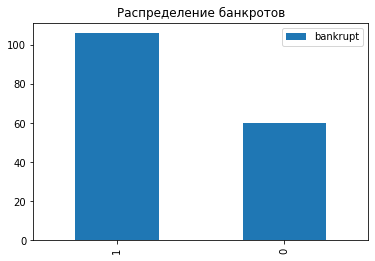

In [49]:
print(df_group['bankrupt'].value_counts())
df_group['bankrupt'].value_counts().plot(kind='bar', label='bankrupt')
plt.legend()
plt.title('Распределение банкротов');

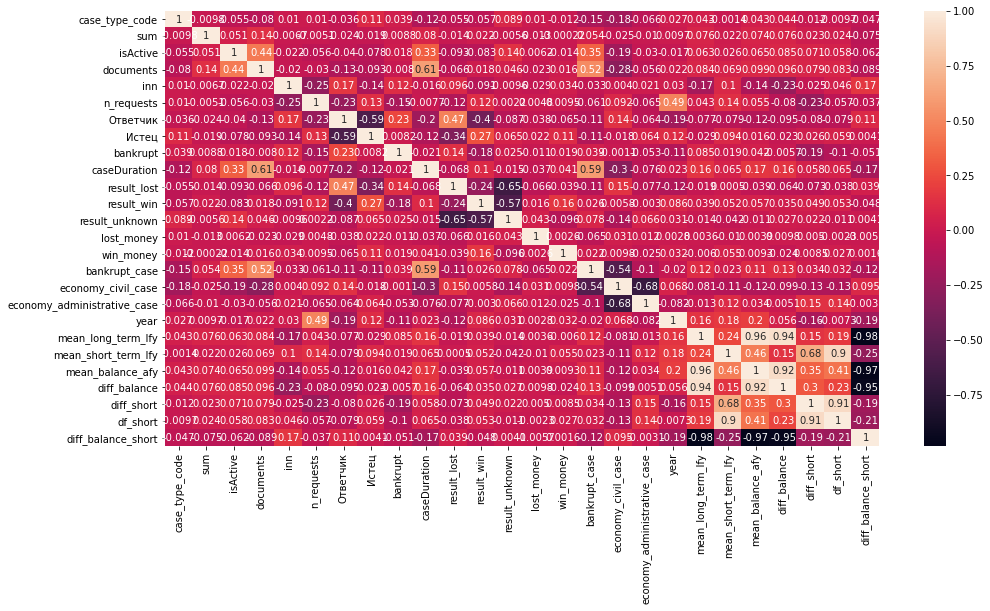

In [50]:
plt.figure(figsize=(16,8))
sns.heatmap(df_new.corr(),annot=True);

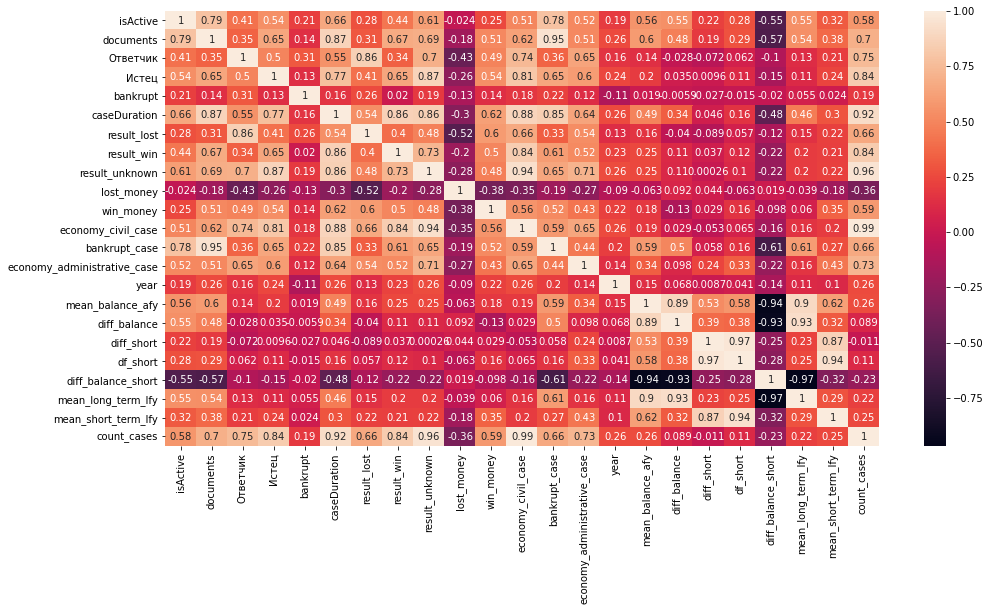

In [51]:
plt.figure(figsize=(16,8))
sns.heatmap(df_group.corr(),annot=True);

После группировки по инн, многи переменные стали коррелировать между с собой. После проведения анализа можно будет убрать переменные, которые чаще и больше всего коррелируют с другими

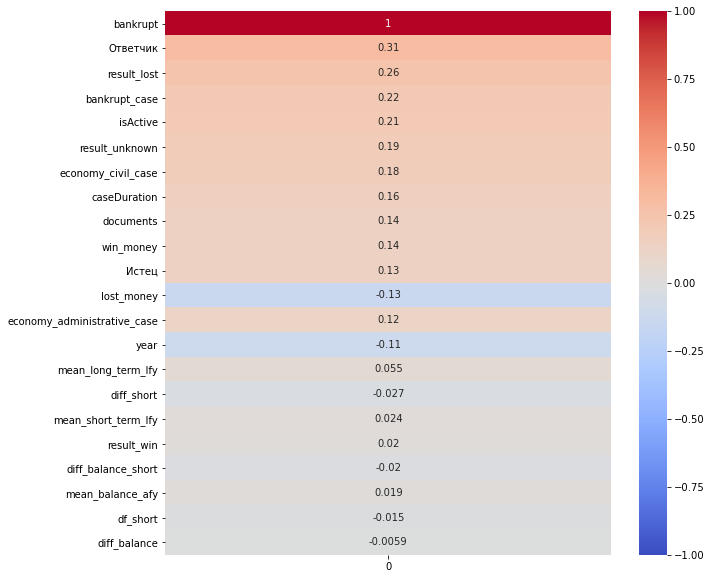

In [52]:
correlations = df_group.corrwith(df_group['bankrupt']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sorted_correlations.to_frame(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

Больше всего с банкротством коррелируют такие переменные сколько раз юр. лицо было Ответчиком, наличие проигранных дел, наличие судов по банкротству. Странно, что активность дел тоже неплохо коррелирует с банкротством.

In [53]:
df_group.describe()

,isActive,documents,Ответчик,Истец,bankrupt,caseDuration,result_lost,result_win,result_unknown,lost_money,...,economy_administrative_case,year,mean_balance_afy,diff_balance,diff_short,df_short,diff_balance_short,mean_long_term_lfy,mean_short_term_lfy,count_cases
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,1.660000e+02,...,166.000000,166.000000,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,166.000000
mean,1.536145,992.174699,21.590361,14.915663,0.638554,11254.054217,10.066265,8.451807,29.903614,-4.816257e+07,...,5.608434,6.234940,1.834765e+08,8.679185e+07,6.301371e+07,1.102856e+08,-8.550096e+08,7.918470e+07,7.948073e+07,48.307229
std,3.389183,2416.943208,40.977314,43.483805,0.481873,24367.228720,23.486717,26.317999,62.111847,2.339275e+08,...,11.917786,2.280135,7.951617e+08,8.380460e+08,3.865952e+08,4.491878e+08,5.947132e+09,6.514323e+08,2.386750e+08,96.804437
min,0.000000,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,-2.218816e+09,...,0.000000,1.000000,6.666667e+03,-1.210091e+09,-5.662660e+08,0.000000e+00,-7.269339e+10,0.000000e+00,0.000000e+00,1.000000
25%,0.000000,56.250000,2.000000,0.000000,0.000000,1060.750000,1.000000,0.000000,3.000000,-1.340540e+07,...,1.000000,4.000000,4.682869e+06,-1.159950e+07,0.000000e+00,1.573250e+06,-1.547760e+08,0.000000e+00,2.405488e+06,4.250000
50%,0.000000,182.000000,8.000000,3.000000,1.000000,4066.000000,2.500000,1.000000,9.000000,-1.542250e+06,...,2.000000,7.000000,2.025571e+07,-4.255000e+05,7.575000e+05,7.787500e+06,-1.433300e+07,0.000000e+00,9.694083e+06,17.500000
75%,1.000000,706.500000,23.000000,9.000000,1.000000,8725.000000,10.750000,5.000000,27.000000,0.000000e+00,...,4.000000,8.000000,8.286929e+07,2.512250e+06,9.124500e+06,3.846975e+07,3.403250e+06,2.887938e+06,4.529479e+07,44.500000
max,24.000000,17023.000000,358.000000,416.000000,1.000000,154262.000000,257.000000,269.000000,480.000000,0.000000e+00,...,99.000000,10.000000,8.454400e+09,9.693328e+09,4.012817e+09,4.842980e+09,1.568897e+09,8.191701e+09,2.549221e+09,623.000000


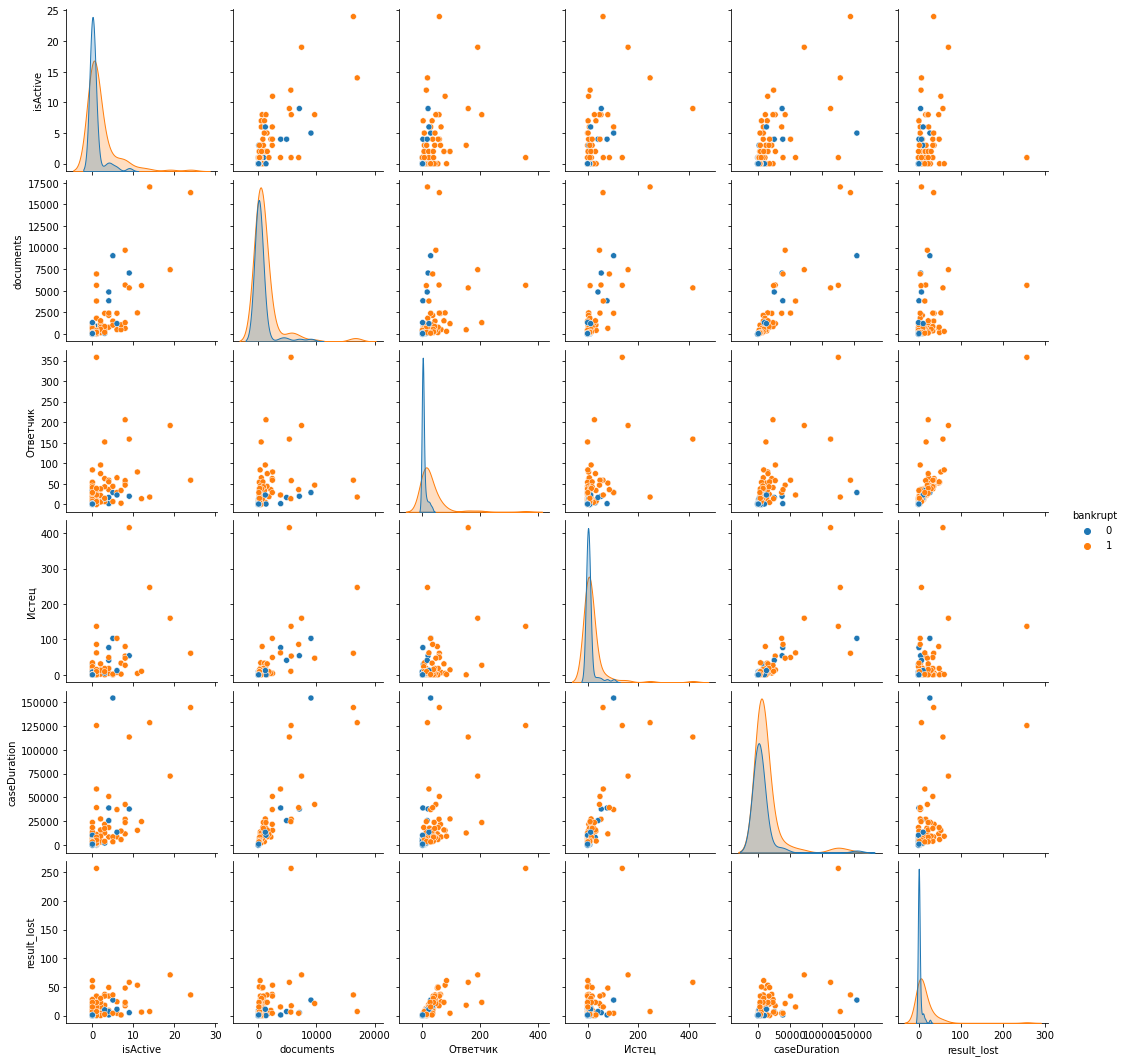

In [54]:
sns.pairplot(df_group.iloc[:,:7], hue='bankrupt');

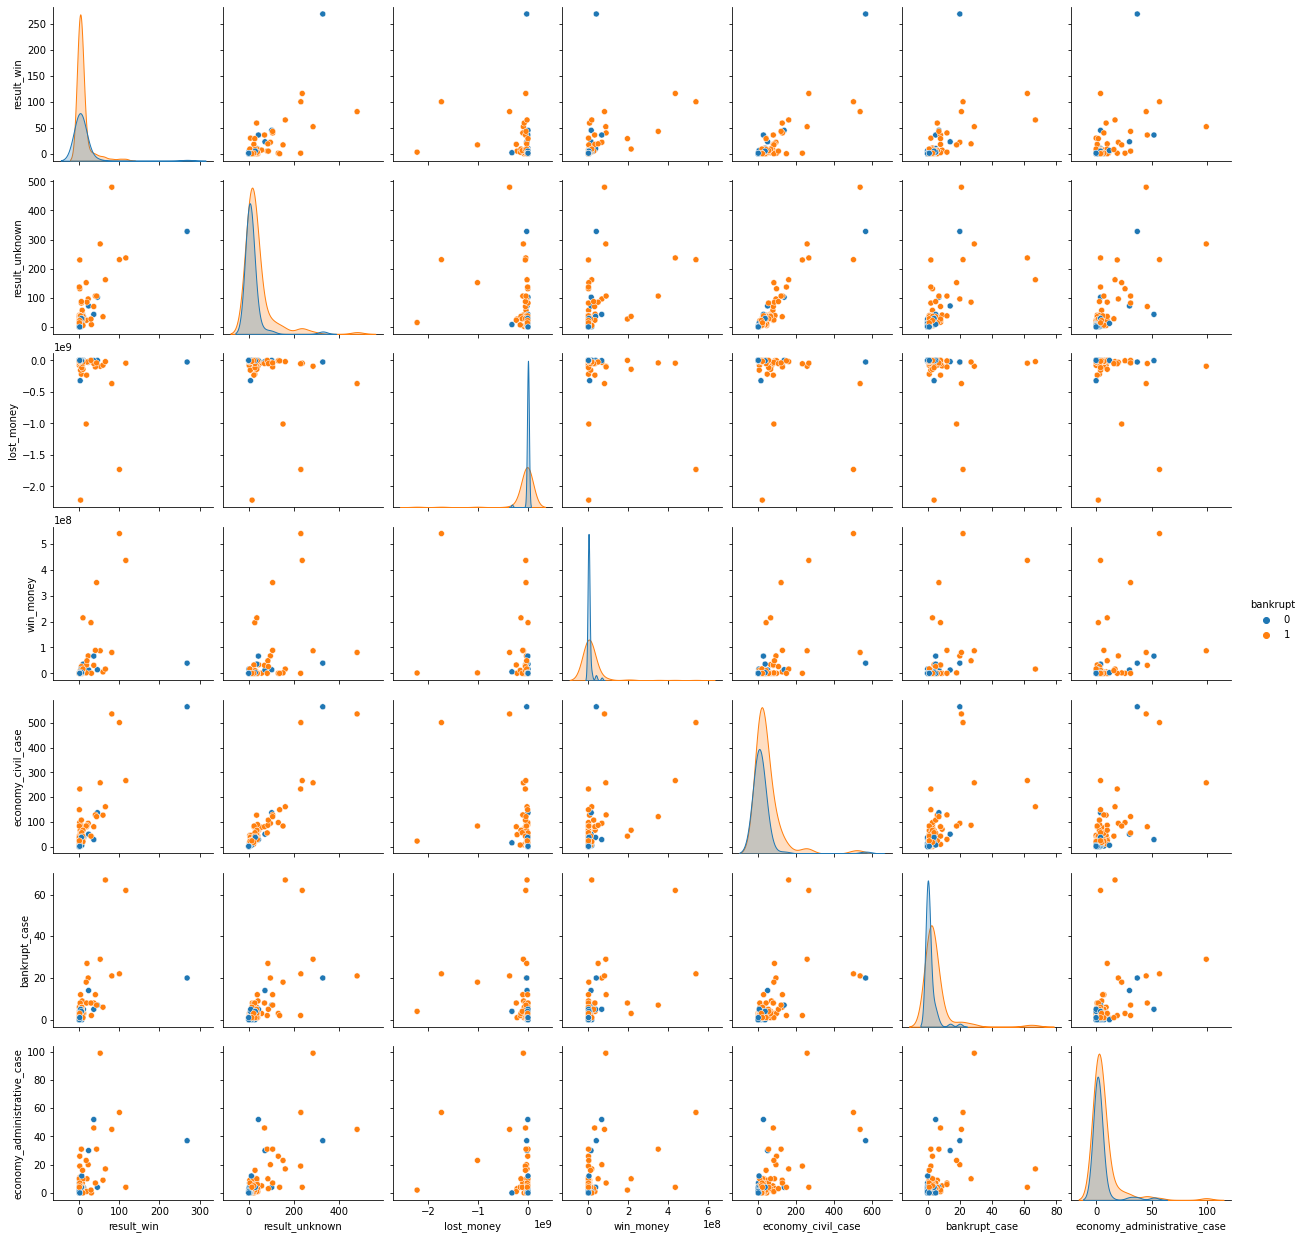

In [55]:
ll = list(df_group.columns[7:14])
ll.append('bankrupt')
sns.pairplot(df_group.loc[:,ll], hue='bankrupt');

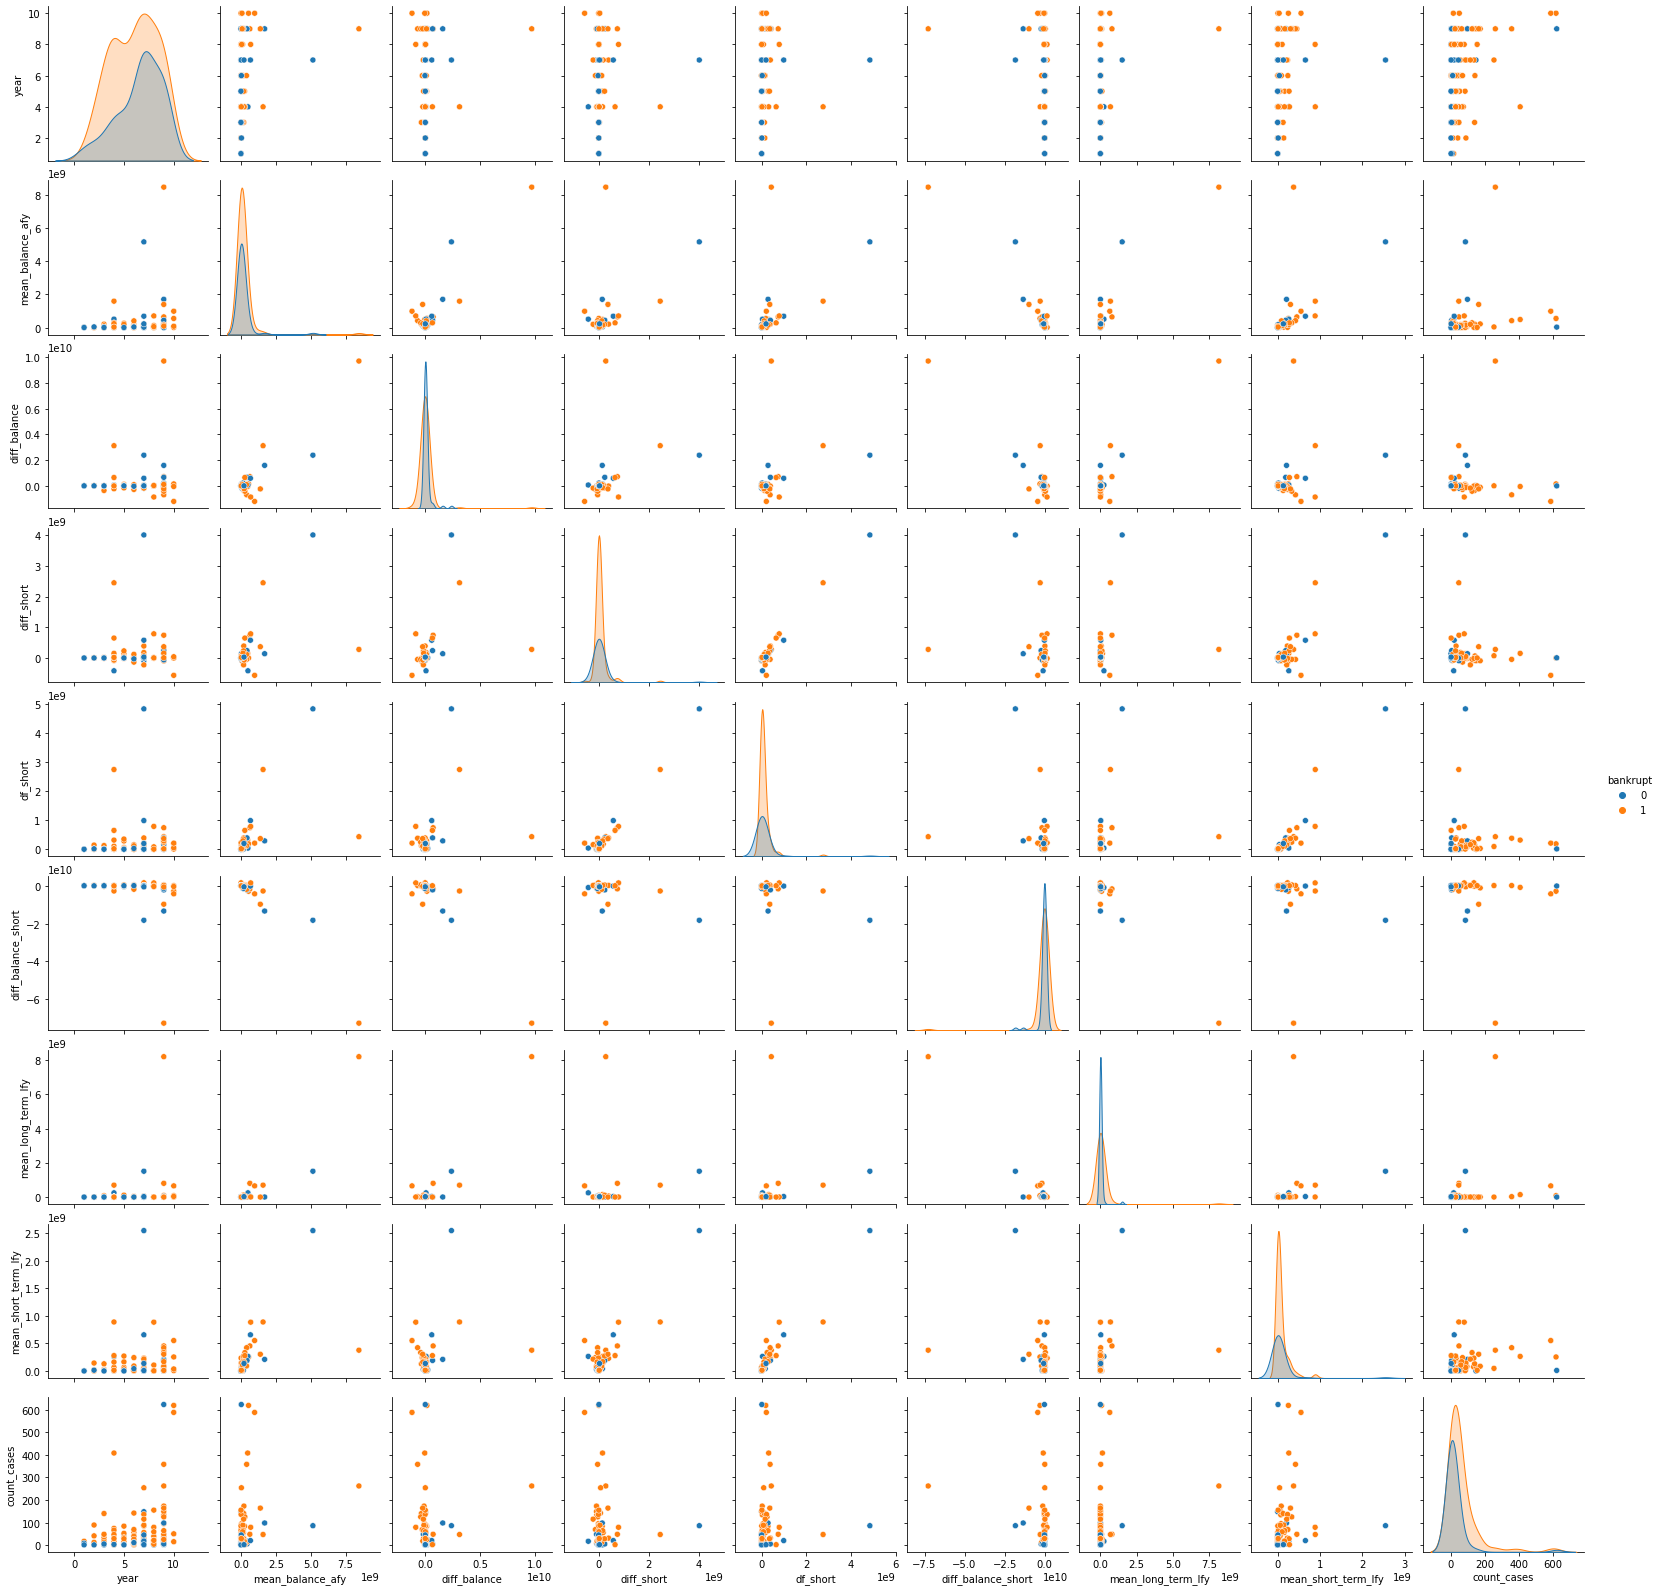

In [56]:
lll = list(df_group.columns[14:])
lll.append('bankrupt')
sns.pairplot(df_group.loc[:,lll], hue='bankrupt');

По парным графикам можно сделать вывод, что небанкроты чаще имеют значение переменных равное нулю, не считая таких переменных как result_win(кол-во побед в судах), mean_balance_afy(средний баланс компании), diff_short(разность последниего краткосрочного долгового обязательства и первого).

In [57]:
df_group.columns

Index(['isActive', 'documents', 'Ответчик', 'Истец', 'bankrupt',
       'caseDuration', 'result_lost', 'result_win', 'result_unknown',
       'lost_money', 'win_money', 'economy_civil_case', 'bankrupt_case',
       'economy_administrative_case', 'year', 'mean_balance_afy',
       'diff_balance', 'diff_short', 'df_short', 'diff_balance_short',
       'mean_long_term_lfy', 'mean_short_term_lfy', 'count_cases'],
      dtype='object')

In [58]:
features =['isActive', 'documents', 'Ответчик', 'Истец', 'bankrupt',
       'caseDuration', 'result_lost', 'result_win', 'result_unknown']

In [59]:
features_2 = ['lost_money', 'win_money','bankrupt_case',
       'economy_administrative_case', 'year', 'mean_balance_afy',
       'diff_balance', 'diff_short', 'df_short', 'diff_balance_short',
       'mean_long_term_lfy', 'mean_short_term_lfy']

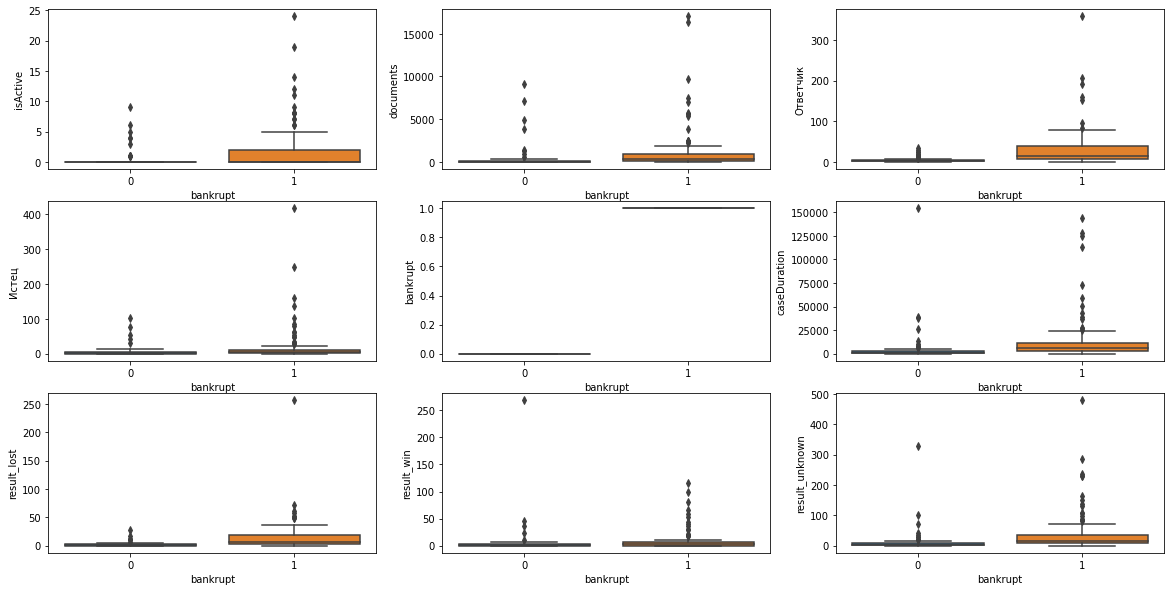

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

for idx, feat in  enumerate(features):
     
    sns.boxplot(x='bankrupt', y=feat, data=df_group, ax=axes[idx//3 , idx % 3])
    #axes[idx//4 , idx % 4].set_title(f'bankrupt with{feat}')
    axes[idx//3 , idx % 3].set_xlabel('bankrupt')
    axes[idx//3 , idx % 3].set_ylabel(feat);

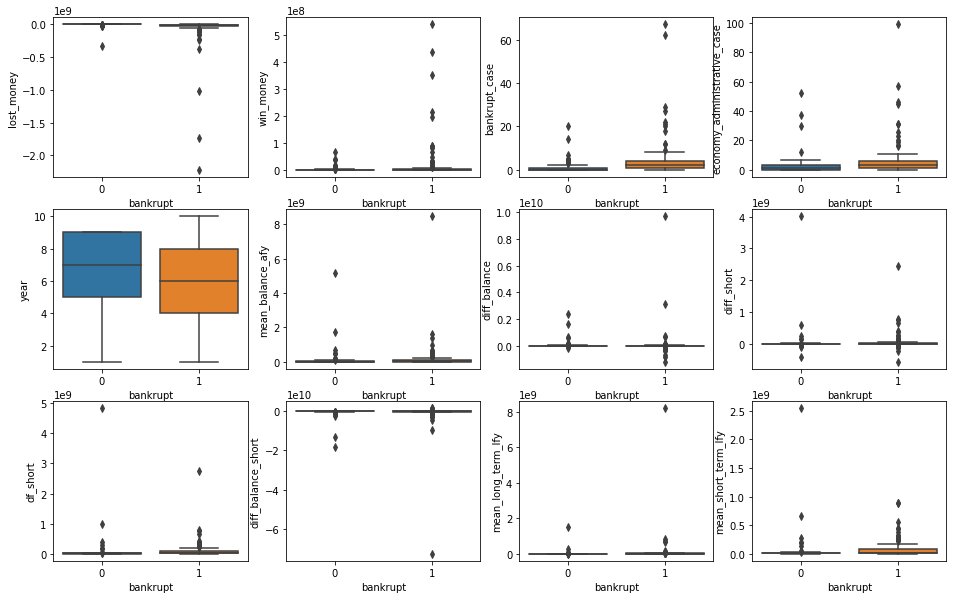

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, feat in  enumerate(features_2):
     
    sns.boxplot(x='bankrupt', y=feat, data=df_group, ax=axes[idx//4 , idx % 4])
    #axes[idx//4 , idx % 4].set_title(f'bankrupt with{feat}')
    axes[idx//4 , idx % 4].set_xlabel('bankrupt')
    axes[idx//4 , idx % 4].set_ylabel(feat);

По бокспотам подтверждается сказанное ранее, что у небанкротов значение как правило около нуля.  
Ещё можно отметить, что наличие большего разброса значений у банкротов и большое количество выбросов.

bankrupt_case,Not bankrupt case,bankrupt case,All
bankrupt,,,
0,43,17,60
1,1,105,106
All,44,122,166


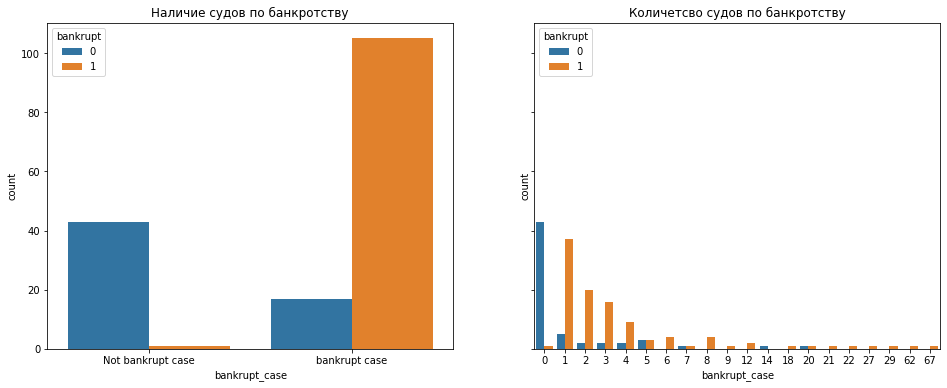

In [62]:
# Как банкротство связанно с участием в судах по банкротству

_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.countplot(x='bankrupt_case', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['bankrupt_case'].apply(lambda x: 'bankrupt case' if x>0 else 'Not bankrupt case'))
                  , axis=1), ax= axes[0]);
axes[0].set_title('Наличие судов по банкротству')
sns.countplot(x='bankrupt_case', hue='bankrupt',
              data=df_group, ax=axes[1]);
axes[1].set_title('Количетсво судов по банкротству')


pd.crosstab(df_group['bankrupt'], 
            df_group['bankrupt_case'].apply(lambda x: 'bankrupt case' if x>0 else 'Not bankrupt case'), margins=True)


In [63]:
# количество не банкротов компании, у которых суд по банкротству длится до сих пор
df_new[(df_new['bankrupt_case']==1)&(df_new['isActive'])&(df_new['bankrupt'] ==0)].inn.nunique()

7

Только у 1 из 106 банкротов не было суда по банкротству.  
А в свою очередь у чуть меньше 30% не банкротов были суды по банкротству, хотя только у 7 компании суд по банкротству длится до сих пор. 
Наличием судов по банкротству может быть сигналом того, что фирма скоро обонкротится.

Ответчик,Не Ответчик,Ответчик,All
bankrupt,,,
0,12,48,60
1,2,104,106
All,14,152,166


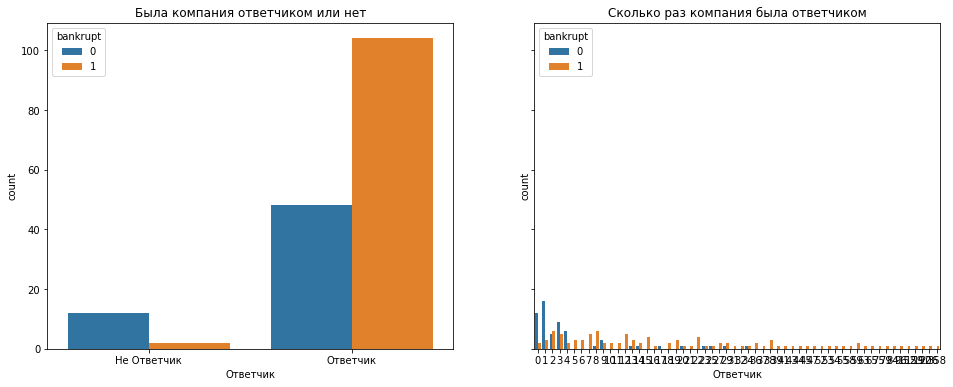

In [64]:
# Как связано банркотсво и то что юр.лицо было ответчиком
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.countplot(x='Ответчик', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['Ответчик'].apply(lambda x: 'Ответчик' if x>0 else 'Не Ответчик'))
                  , axis=1), ax=axes[0]);
axes[0].set_title('Была компания ответчиком или нет');
sns.countplot(x='Ответчик', hue='bankrupt',
              data=df_group, ax=axes[1]);
axes[1].set_title('Сколько раз компания была ответчиком');
pd.crosstab(df_group['bankrupt'], 
            df_group['Ответчик'].apply(lambda x: 'Ответчик' if x>0 else 'Не Ответчик'), margins=True)


Среди банкротов только 2 из 106 не были ответчиками, а среди не банкротов 80 % были ответчиками. Но на правом графике видно, чем чаще компания бывает ответчиком, тем больше вероятность что она банкрот.

result_lost,not result_lost,result_lost,All
bankrupt,,,
0,29,31,60
1,11,95,106
All,40,126,166


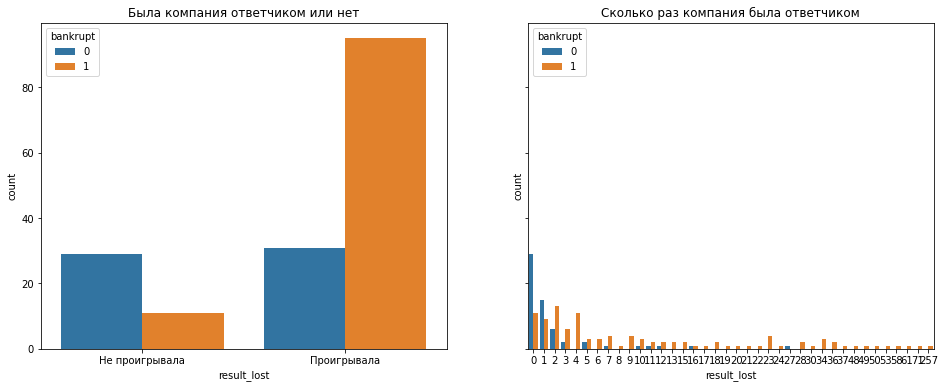

In [65]:
# Как связано банркотсво и проигрыш в суде
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.countplot(x='result_lost', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['result_lost'].apply(lambda x: 'Проигрывала' if x>0 else 'Не проигрывала'))
                  , axis=1), ax=axes[0]);
axes[0].set_title('Была компания ответчиком или нет');
sns.countplot(x='result_lost', hue='bankrupt',
              data=df_group, ax=axes[1]);
axes[1].set_title('Сколько раз компания была ответчиком');
pd.crosstab(df_group['bankrupt'], 
            df_group['result_lost'].apply(lambda x: 'result_lost' if x>0 else 'not result_lost'), margins=True)


Чем больше проигрышей, тем выше вероятность, что компания банкрот

result_unknown,0,1,All
bankrupt,,,
0,5,55,60
1,1,105,106
All,6,160,166


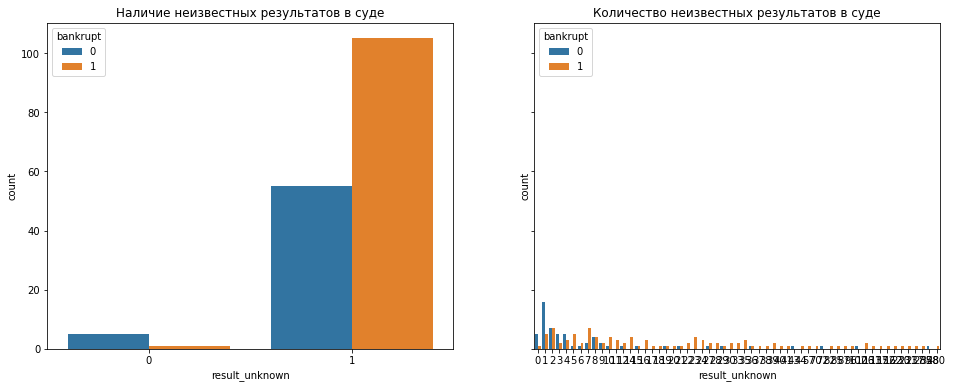

In [66]:
# Как связано банркотсво и наличие неизвестных результатов в суде
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.countplot(x='result_unknown', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['result_unknown'].apply(lambda x: 1 if x>0 else 0))
                  , axis=1),ax = axes[0]);
axes[0].set_title('Наличие неизвестных результатов в суде');
sns.countplot(x='result_unknown', hue='bankrupt',
              data=df_group, ax=axes[1]);
axes[1].set_title('Количество неизвестных результатов в суде');
pd.crosstab(df_group['bankrupt'], df_group['result_unknown'].apply(lambda x: 1 if x>0 else 0), margins=True)

Данная переменная в основом передаёт информацию о тех случаях в судах, когда результат не удалось установить. На мой вгляд её можно удалить, так как эта информация никак не поможет модели при обучении

economy_civil_case,0,1,All
bankrupt,,,
0,8,52,60
1,4,102,106
All,12,154,166


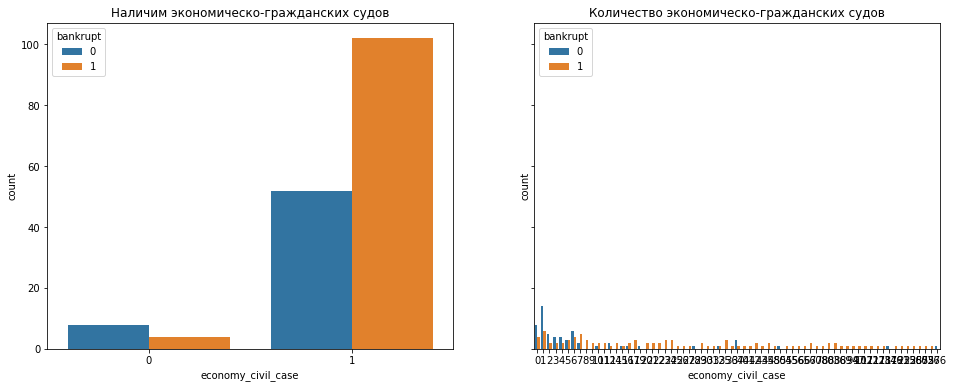

In [67]:
# Связь банкротства с наличим экономическо-гражданских судов
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.countplot(x='economy_civil_case', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['economy_civil_case'].apply(lambda x: 1 if x>0 else 0))
                  , axis=1), ax = axes[0]);
axes[0].set_title('Наличим экономическо-гражданских судов');
sns.countplot(x='economy_civil_case', hue='bankrupt',
              data=df_group, ax=axes[1]);
axes[1].set_title('Количество экономическо-гражданских судов');
pd.crosstab(df_group['bankrupt'], df_group['economy_civil_case'].apply(lambda x: 1 if x>0 else 0), margins=True)

isActive,0,1,2,3,4,5,6,7,8,9,11,12,14,19,24,All
bankrupt,,,,,,,,,,,,,,,,
0,49,5,0,1,2,1,1,0,0,1,0,0,0,0,0,60
1,55,19,8,5,3,2,2,2,4,1,1,1,1,1,1,106
All,104,24,8,6,5,3,3,2,4,2,1,1,1,1,1,166


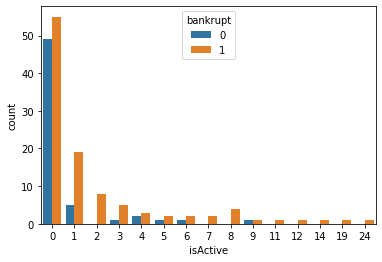

In [68]:
# Связь активных дел с банкротством 
sns.countplot(x='isActive', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['isActive'])
                  , axis=1));
pd.crosstab(df_group['bankrupt'], df_group['isActive'], margins=True)

lost_money,0,1,All
bankrupt,,,
0,34,26,60
1,17,89,106
All,51,115,166


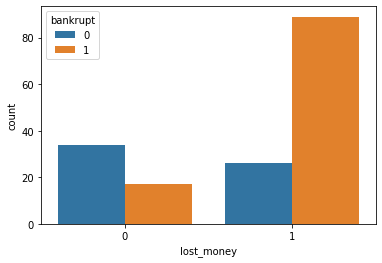

In [69]:
# Связь банкротства с потерей денег в судах 
sns.countplot(x='lost_money', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['lost_money'].apply(lambda x: 1 if x<0 else 0))
                  , axis=1));
pd.crosstab(df_group['bankrupt'], df_group['lost_money'].apply(lambda x: 1 if x<0 else 0), margins=True)

Банкроты чаще теряют деньги в судах, чем не банкроты. Но данный признак все равно явно не разделяет банкротов и не банкротов, потому что 30% не банкротов теряли деньги в судах.

win_money,0,1,All
bankrupt,,,
0,38,22,60
1,53,53,106
All,91,75,166


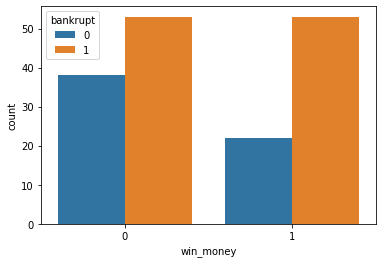

In [70]:
# Связь банкротства с выигранными средствами в судах 
sns.countplot(x='win_money', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['win_money'].apply(lambda x: 1 if x>0 else 0))
                  , axis=1));
pd.crosstab(df_group['bankrupt'], df_group['win_money'].apply(lambda x: 1 if x>0 else 0), margins=True)

Для выйгранных денег, можно увидеть, что разницы для банкротов и не банкротов практически никакой нет, поэтому можно будет избавится от этого признака.

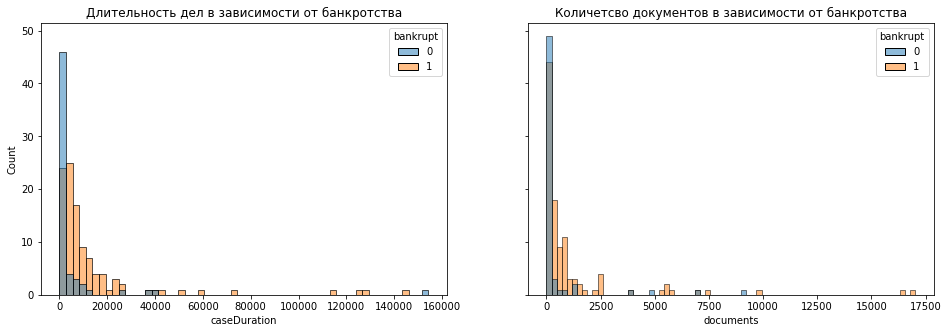

In [71]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,5))
sns.histplot(data = df_group, x = 'caseDuration', hue='bankrupt', ax=axes[0])
axes[0].set_title('Длительность дел в зависимости от банкротства')
sns.histplot(data = df_group, x = 'documents', hue='bankrupt', ax=axes[1])
axes[1].set_title('Количетсво документов в зависимости от банкротства');

В основном у банкротов дела длятся дольше и количество документов больше. Эти признаки весьма похожи, поэтому в конечную модель пойдет только одиг из них

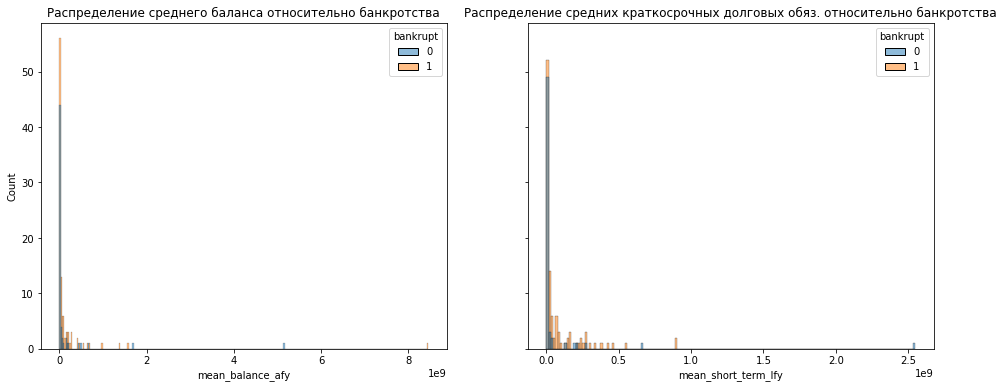

In [72]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.histplot(data = df_group, x = 'mean_balance_afy', hue='bankrupt', ax=axes[0])
axes[0].set_title('Распределение среднего баланса относительно банкротства')
sns.histplot(data = df_group, x = 'mean_short_term_lfy', hue='bankrupt', ax=axes[1])
axes[1].set_title('Распределение средних краткосрочных долговых обяз. относительно банкротства');

In [73]:
df_group.mean_balance_afy.describe(), df_group.mean_short_term_lfy.describe()

(count    1.660000e+02
 mean     1.834765e+08
 std      7.951617e+08
 min      6.666667e+03
 25%      4.682869e+06
 50%      2.025571e+07
 75%      8.286929e+07
 max      8.454400e+09
 Name: mean_balance_afy, dtype: float64,
 count    1.660000e+02
 mean     7.948073e+07
 std      2.386750e+08
 min      0.000000e+00
 25%      2.405488e+06
 50%      9.694083e+06
 75%      4.529479e+07
 max      2.549221e+09
 Name: mean_short_term_lfy, dtype: float64)

In [74]:
df_group.mean_balance_afy.sort_values(),df_group.mean_short_term_lfy.sort_values()

(inn
 5404263460    6.666667e+03
 7802646458    2.700000e+04
 4029028408    4.314286e+04
 5638055144    9.257143e+04
 7841475679    2.016667e+05
                   ...     
 7725239857    1.390026e+09
 7728812071    1.586312e+09
 3525119121    1.697954e+09
 5009033730    5.157982e+09
 2226001190    8.454400e+09
 Name: mean_balance_afy, Length: 166, dtype: float64,
 inn
 7802646458    0.000000e+00
 3217002312    0.000000e+00
 5404263460    6.666667e+02
 4029028408    2.957143e+04
 2266005106    9.814286e+04
                   ...     
 6725005494    5.524565e+08
 7722651420    6.566766e+08
 7724793607    8.863070e+08
 7728812071    8.895422e+08
 5009033730    2.549221e+09
 Name: mean_short_term_lfy, Length: 166, dtype: float64)

In [75]:
df_group.drop([5009033730,2226001190], inplace=True)

Удалил несколько явных выбросов, можно удалить ещё, но учитывая размер получившегося датафрейма думаю не стоит.

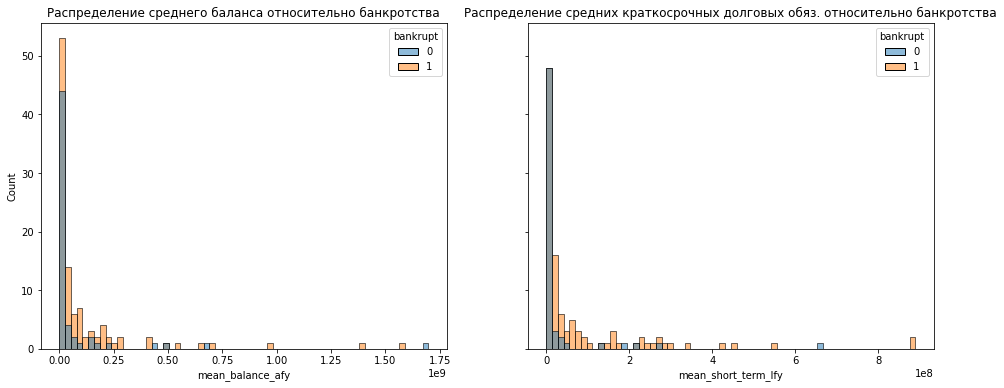

In [76]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.histplot(data = df_group, x = 'mean_balance_afy', hue='bankrupt', ax=axes[0])
axes[0].set_title('Распределение среднего баланса относительно банкротства')
sns.histplot(data = df_group, x = 'mean_short_term_lfy', hue='bankrupt', ax=axes[1])
axes[1].set_title('Распределение средних краткосрочных долговых обяз. относительно банкротства');

Для банкротов наличие краткосрочных обязательств более характерны

In [77]:
df_group.mean_long_term_lfy.describe()

count    1.640000e+02
mean     2.100800e+07
std      9.943372e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.550750e+06
max      8.025036e+08
Name: mean_long_term_lfy, dtype: float64

In [78]:
df_group.mean_long_term_lfy.value_counts()

0.000000e+00    84
1.112684e+08     1
5.977778e+04     1
7.842467e+07     1
2.471280e+08     1
                ..
2.166000e+06     1
2.066667e+05     1
1.388889e+04     1
5.519600e+06     1
4.577143e+06     1
Name: mean_long_term_lfy, Length: 81, dtype: int64

mean_long_term_lfy,0,1,All
bankrupt,,,
0,33,26,59
1,51,54,105
All,84,80,164


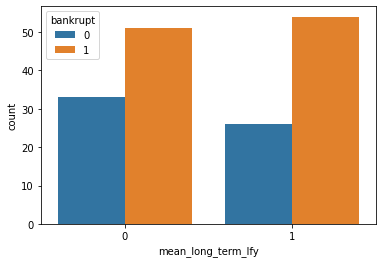

In [79]:
sns.countplot(x='mean_long_term_lfy', hue='bankrupt',
              data=pd.concat(
                  (df_group['bankrupt'],
                   df_group['mean_long_term_lfy'].apply(lambda x: 1 if x>0 else 0))
                  , axis=1));
pd.crosstab(df_group['bankrupt'], df_group['mean_long_term_lfy'].apply(lambda x: 1 if x>0 else 0), margins=True)

У долгосрочных долговых обязательств больше половины значений равны нулю, вспомнив тот факт, что в первоначальном датафрейме некоторые значения были пропущены можно задуматься о исключении этого признака.

### Итог EDA
В результате анилиза была выявлена сильная корреляция между признаками, что наводит о мысли сократить кол-во использьуемых признаков в модели.  
Самыми выделяющимися признаками, можно считать bankrupt_case , Ответчик, result_lost. Важно отметить, что bankrupt_case были не только среди банкротов, но и среди не банкротов, что кажется весьма странным. Также можно выделить длительность дел, количество документов, потерянные деньги в судах и кроткосрочные обязательства.  
При построении модели нужно будет уделить внимание отбору признаков.

# 3.Выбор метрики и построение модели

В случае если задача модели помощь в выдаче кредита компаниям лучше всего подойдет метрика recall, так как она отвечает за полноту найденых банкротов, то есть чем она выше, тем выше процент найденных банкротов и тем меньше несет убытков банк выдавая им кредит.
С другой стороны если бы мы выбрали метрику Precision, то минимизировали кол-во ошибочно определенных банкротов, что увеличило бы прибыль банка.  
Но учитывая тот факт, что один выданный кредит навряд ли приносит нам больше половины выданной суммы, то лучше будет перестраховаться и не дать кредит, чем ошибится и дать его будущему банкроту.
Но в наших данных банкротов больше примерно в полтора раза (100 - 1 /60 - 0) и если использовать метрику recall, то модель может начать всех определять как банкротов и увеличивать долю правильных ответ.  
Так что в нашем случае лучше выбрать **ROC AUC** метрику, чтобы как можно точнее определять и тот и другой класс.

In [80]:
new_groups_feats = df_group.loc[:,['isActive','documents',
              'Ответчик','Истец','bankrupt','caseDuration','result_lost','result_win',
              'result_unknown','year','mean_long_term_lfy',
              'mean_short_term_lfy','mean_balance_afy',
              'diff_balance','diff_short','df_short','diff_balance_short',
               'bankrupt_case', 'economy_civil_case',
       'economy_administrative_case', 'lost_money', 'win_money' ]]

In [81]:
X = new_groups_feats.drop('bankrupt', axis=1)
y = new_groups_feats['bankrupt']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.4 ,random_state=5)

Для данной задачи я выбрал RandomForest, так как он менее чуствителен к выбросам из-за сэмплирования, хорошо справляется с разным масштабом данных , а также можно будет посмотреть на важность признаков и отобрать самые влиятельные в конечную модель.

In [82]:
skf = StratifiedKFold(n_splits=10)
rf = RandomForestClassifier(n_estimators=100, random_state=5)
cv_score_rf = cross_val_score(rf,X_train, y_train, cv = skf,scoring='roc_auc')

In [83]:
print(f'Results of cv : {cv_score_rf}')
print(f'Mean cv :{cv_score_rf.mean()}, Std of cv {cv_score_rf.std()}')

Results of cv : [1.         0.91666667 1.         1.         1.         0.95238095
 1.         0.9047619  0.83333333 1.        ]
Mean cv :0.9607142857142857, Std of cv 0.05534113951985455


In [84]:
rf.fit(X_train,y_train)
rfpred = rf.predict(X_test)
print(f'accuracy:{accuracy_score(y_test, rfpred):.3f} , precision: {precision_score(y_test, rfpred):.3f}')
print(f'recall: {recall_score(y_test,rfpred):.3f}, roc_auc:{roc_auc_score(y_test,rfpred):.3f}')

accuracy:0.818 , precision: 0.812
recall: 0.929, roc_auc:0.777


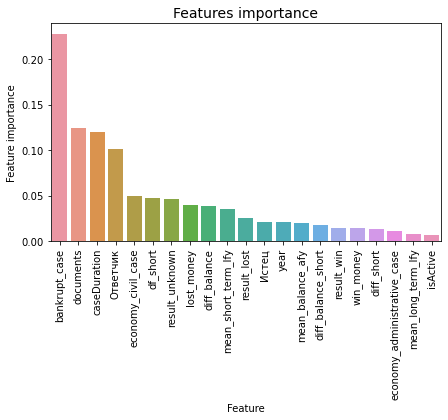

In [85]:
# Построим диаграмму важности признаков для модели rf
tmp = pd.DataFrame({'Feature': X.columns, 'Feature importance': abs(rf.feature_importances_.reshape(-1,))})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [86]:
X_train.shape

(98, 21)

Как и предпологалось bankrupt_case самый важный признак по результат RandomForest.  
По кросс валидации видно, что иногда мы получали 100% ROC-AUC, думаю это связано с размером нашей выборки, всего лишь 98 строк на трейне и 66 в тесте. Отберем фичи основываясь на диаграмме важности признаков и проведенном EDA.

In [87]:
new_groups_feats_1 = df_group.loc[:,[
              'Ответчик','bankrupt','documents','result_lost',
              'year', 'mean_short_term_lfy','diff_balance',
              'economy_civil_case', 'bankrupt_case', 'lost_money' ]]

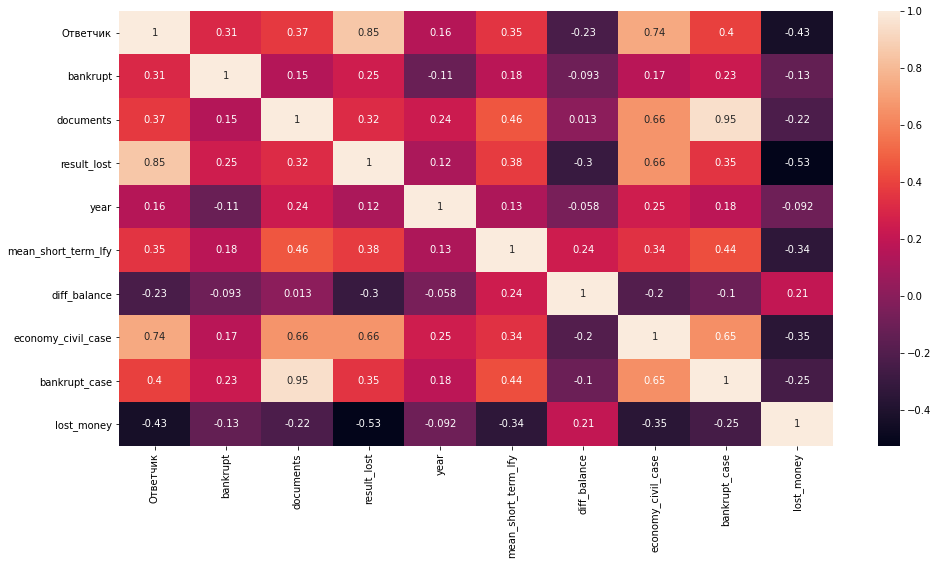

In [88]:
plt.figure(figsize=(16,8))
sns.heatmap(new_groups_feats_1.corr(),annot=True);

In [89]:
X_new = new_groups_feats_1.drop('bankrupt', axis=1)
y_new = new_groups_feats_1['bankrupt']

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new.values, y_new.values,
                                                                    test_size=0.4 ,random_state=5)

In [90]:
skf = StratifiedKFold(n_splits=10)
rf_new = RandomForestClassifier(n_estimators=100,random_state=1)
cv_score_rf_new = cross_val_score(rf,X_new_train, y_new_train, cv = skf,scoring='roc_auc')

In [91]:
print(f'Results of cv : {cv_score_rf_new}')
print(f'Mean cv :{cv_score_rf_new.mean()}, Std of cv {cv_score_rf_new.std()}')

Results of cv : [1.         0.95833333 1.         0.91666667 1.         0.95238095
 1.         0.9047619  0.94444444 1.        ]
Mean cv :0.9676587301587303, Std of cv 0.03556018340772342


In [92]:
rf_new.fit(X_new_train,y_new_train)
rf_new_pred = rf_new.predict(X_new_test)
print(f'accuracy:{accuracy_score(y_new_test, rf_new_pred):.3f} , precision: {precision_score(y_new_test, rf_new_pred):.3f}')
print(f'recall: {recall_score(y_new_test, rf_new_pred):.3f}, roc_auc:{roc_auc_score(y_new_test, rf_new_pred):.3f}')

accuracy:0.833 , precision: 0.830
recall: 0.929, roc_auc:0.798


In [93]:
params = {'n_estimators':range(50,300,50),
    'max_depth':range(1,15,5),
    'min_samples_split':range(2,15,3),
    'min_samples_leaf':range(1,10,2),
    'max_features':range(1,10,3)
    }
grid = GridSearchCV(rf, params, scoring='roc_auc', cv=skf,verbose=True)
grid.fit(X_new_train,y_new_train)

Fitting 10 folds for each of 1125 candidates, totalling 11250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': range(1, 15, 5),
                         'max_features': range(1, 10, 3),
                         'min_samples_leaf': range(1, 10, 2),
                         'min_samples_split': range(2, 15, 3),
                         'n_estimators': range(50, 300, 50)},
             scoring='roc_auc', verbose=True)

In [94]:
print(f'Best params:{grid.best_params_}')

Best params:{'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [95]:
grid_pred = grid.predict(X_new_test)
print(f'accuracy:{accuracy_score(y_new_test, grid_pred):.3f} , precision: {precision_score(y_new_test, grid_pred):.3f}')
print(f'recall: {recall_score(y_new_test, grid_pred):.3f}, roc_auc:{roc_auc_score(y_new_test, grid_pred):.3f}')

accuracy:0.864 , precision: 0.837
recall: 0.976, roc_auc:0.821


После размытого подбора параметров качество модели улучшилось.  
Подберем параметры более точно

In [97]:
params = {'n_estimators':range(80,131,10),
    'max_depth':range(3,8),
    'min_samples_split':range(6,10),
    'min_samples_leaf':range(2,4),
    'max_features':range(7,10)
    }
grid_last = GridSearchCV(rf, params, scoring='roc_auc', cv=skf,verbose=True)
grid_last.fit(X_new_train,y_new_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': range(3, 8), 'max_features': range(7, 10),
                         'min_samples_leaf': range(2, 4),
                         'min_samples_split': range(6, 10),
                         'n_estimators': range(80, 131, 10)},
             scoring='roc_auc', verbose=True)

In [98]:
print(f'Best params:{grid.best_params_}')

Best params:{'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


На более точечном подбор гридсерче пришел к тем же параметрам.  
Построим кривую обучения, чтобы посмотреть как количество данных влияют на качество модели.

In [100]:
def plot_learning_curve(estimator1, X, y, cv=None,
                        train_sizes=np.array([0.1  , 0.325, 0.55 , 0.775, 1])):
    plt.figure(figsize=(12,6))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    plt.title("Logistic Regression Learning Curve", fontsize=14)
    plt.xlabel('Training size (m)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")

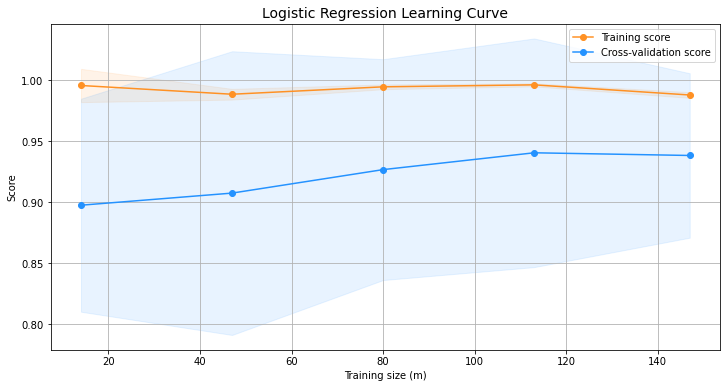

In [101]:
plot_learning_curve(grid_last.best_estimator_, X_new, y_new, cv=skf)

Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации.

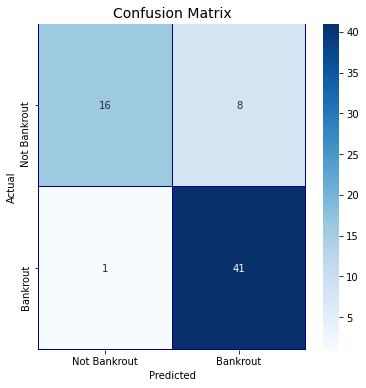

In [102]:
cm = pd.crosstab(y_test, grid_pred_last, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(6,6))
sns.heatmap(cm, 
            xticklabels=['Not Bankrout', 'Bankrout'],
            yticklabels=['Not Bankrout', 'Bankrout'],
            annot=True,fmt="d",ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

По матрице сопреженности видно, что у нас получился очень высокий recall 41/42 = 0.976, а precision получилось ниже 41/49 = 0.836. Учитывая что в классе не банкроты всего 24 компании, а 8 из них были помечены как ложно положительные, но как я говорил ранее при подборе метрики, показатель recall для нас важнее, чем pricison. 

### Вывод:
Нельзя сказать, что данная модель очень хорошо показывает себя, виной тому весьма малый набор данных после группировки по инн. Но я считаю, что группировка это лучшее решение, так как если добавить данных в такую модель то качество улучшится по сравнению, если бы например без группировки усредняли результат по предсказанным значениям для каждого инн. Ещё можно отметить весьма подозрительную фичу как наличие судов по банкротству, возможно стоит её вынести в отдельный тревожный сигнал банку, так как при построении модели, алгоритм начинает переобучаться под неё.